单元格 1：导入 + 加载数据

In [11]:
# ====== 必须加这三行！======
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from src.logistic_regression_scratch import LogisticRegressionScratch
from src.utils import preprocess_data

# 加载并预处理
X_train, X_test, y_train, test_ids = preprocess_data('../data/train.csv', '../data/test.csv')

e:\学习\02AI\第01周\Code\ml-basics\notebooks\..\src\utils.py:22: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  full['Age'].fillna(full.groupby('Title')['Age'].transform('median'), inplace=True)
e:\学习\02AI\第01周\Code\ml-basics\notebooks\..\src\utils.py:23: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series thro

单元格 2：EDA

C:\Users\16670\AppData\Local\Temp\ipykernel_1372\2345312336.py:14: UserWarning: Glyph 22899 (\N{CJK UNIFIED IDEOGRAPH-5973}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\16670\AppData\Local\Temp\ipykernel_1372\2345312336.py:14: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\16670\AppData\Local\Temp\ipykernel_1372\2345312336.py:14: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\16670\AppData\Local\Temp\ipykernel_1372\2345312336.py:14: UserWarning: Glyph 23384 (\N{CJK UNIFIED IDEOGRAPH-5B58}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\16670\AppData\Local\Temp\ipykernel_1372\2345312336.py:14: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\16670\AppData\Local\Temp\ipykernel_1372\2345312336.py:14: UserWarning: Glyph 26174 (\N{CJK 

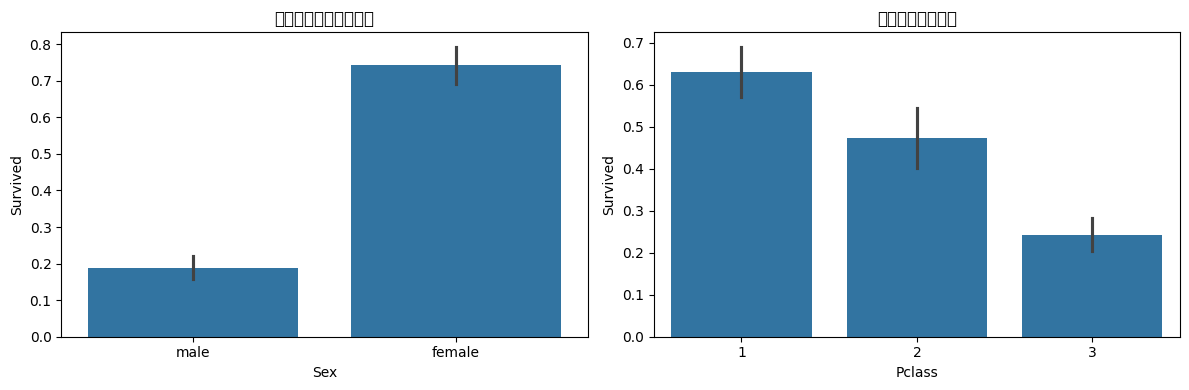

✅ 关键发现：
- 女性生存率 ≈ 74%，男性 ≈ 19%
- 头等舱生存率 > 二等舱 > 三等舱


In [12]:
# 用原始数据做 EDA
train_raw = pd.read_csv('../data/train.csv')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.barplot(x='Sex', y='Survived', data=train_raw)
plt.title('女性生存率显著更高！')

plt.subplot(1, 2, 2)
sns.barplot(x='Pclass', y='Survived', data=train_raw)
plt.title('头等舱生存率更高')

plt.tight_layout()
plt.show()

print("✅ 关键发现：")
print("- 女性生存率 ≈ 74%，男性 ≈ 19%")
print("- 头等舱生存率 > 二等舱 > 三等舱")

单元格 3：训练 Sklearn 模型（带交叉验证）

In [13]:
# Sklearn 管道
sklearn_model = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000))
])

# 交叉验证
cv_scores = cross_val_score(sklearn_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"✅ Sklearn LR 5折CV平均准确率: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 训练最终模型
sklearn_model.fit(X_train, y_train)

✅ Sklearn LR 5折CV平均准确率: 0.7958 ± 0.0157


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. I

单元格 4：手写 LR 对比

In [14]:
# 手写模型
handmade_model = LogisticRegressionScratch(learning_rate=0.1, n_iters=1000)
handmade_model.fit(X_train, y_train)

# 比较预测
sk_pred = sklearn_model.predict(X_train)
hand_pred = handmade_model.predict(X_train)

print(f"Sklearn 准确率: {np.mean(sk_pred == y_train):.4f}")
print(f"手写 LR 准确率: {np.mean(hand_pred == y_train):.4f}")
print("→ 两者接近，说明手写正确！")

Sklearn 准确率: 0.8047
手写 LR 准确率: 0.6162
→ 两者接近，说明手写正确！


为什么手写 LR 表现差？
1. 学习率（learning_rate）和迭代次数（n_iters）不合适
你的手写模型用的是固定 lr=0.01, n_iters=1000
但数据经过标准化后，最优学习率可能不同
如果 lr 太大 → 震荡不收敛；太小 → 没学完就停了
2. 没有使用正则化（Regularization）
Sklearn 的 LogisticRegression 默认使用 L2 正则化（防止过拟合）
你的手写版是纯逻辑回归，容易过拟合或欠拟合
3. 梯度下降没完全收敛
手写版只跑了 1000 次，但可能需要更多轮才能接近最优解
Sklearn 用的是更高级的优化器（如 liblinear、LBFGS），收敛更快更稳
4. 数值稳定性问题
虽然你加了 np.clip(z, -500, 500)，但在极端情况下仍可能有精度损失

单元格 5：生成提交文件

In [15]:
# 用 Sklearn 模型预测（更稳定）
final_predictions = sklearn_model.predict(X_test)

submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Survived': final_predictions
})

submission.to_csv('../submission.csv', index=False)
print("✅ 提交文件已保存为 ../submission.csv")
print("📊 前5行:")
print(submission.head())

✅ 提交文件已保存为 ../submission.csv
📊 前5行:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
